In [47]:
# Install the required libraries
!pip install prophet

In [48]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
from prophet import Prophet
from matplotlib import pyplot as plt
import gdown
%matplotlib inline

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
#URLs for downloading the updated forecast files
url_bitcoin = 'https://drive.google.com/uc?id=1g_bLlJpB0B9TkPEnTwCmeGlhZVqTOZ5L'
gdown.download(url_bitcoin, 'Bitcoin_Data.csv', quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1g_bLlJpB0B9TkPEnTwCmeGlhZVqTOZ5L
To: /content/Bitcoin_Data.csv
100%|██████████| 161k/161k [00:00<00:00, 83.7MB/s]


'Bitcoin_Data.csv'

In [51]:
#URLs for downloading the sp500
url_sp500 = 'https://drive.google.com/uc?id=1jZh57xNk_c2YjUsidpPO2GiS6n_ZD3jr'
gdown.download(url_sp500, 'SP500_Data.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1jZh57xNk_c2YjUsidpPO2GiS6n_ZD3jr
To: /content/SP500_Data.csv
100%|██████████| 55.4k/55.4k [00:00<00:00, 59.5MB/s]


'SP500_Data.csv'

In [52]:
#Read the URL_Bitcoin into a dataframe
bitcoin_df = pd.read_csv(url_bitcoin,
                 index_col="Date",
                 parse_dates=True
                )

# Drop any values that are blank
bitcoin_df = bitcoin_df.dropna()

# Drop Column '% Change'
bitcoin_df = bitcoin_df.drop(columns="Change %")

# Preview the dataset
bitcoin_df.head()

,Price,Open,High,Low,Vol.
Date,,,,,
2024-12-09,"97,359.4","101,129.7","101,198.6","94,395.8",321.01K
2024-12-08,"101,115.8","99,837.0","101,339.9","98,713.9",128.93K
2024-12-07,"99,837.0","99,757.2","100,441.8","98,969.0",118.44K
2024-12-06,"99,760.7","96,968.9","101,908.5","96,452.0",213.49K
2024-12-05,"96,970.8","98,624.8","103,719.4","92,510.4",245.79K


In [53]:
#Read the URL_SP500 into a dataframe
sp500_df = pd.read_csv(url_sp500,
                 index_col="Date",
                 parse_dates=True
                )

# Drop any values that are blank
sp500_df = sp500_df.dropna()

# Preview the dataset
sp500_df.head()

,Close/Last,Open,High,Low
Date,,,,
2024-12-06,6090.27,6081.38,6099.97,6079.98
2024-12-05,6075.11,6089.03,6094.55,6072.90
2024-12-04,6086.49,6069.39,6089.84,6061.06
2024-12-03,6049.88,6042.97,6052.07,6033.39
2024-12-02,6047.15,6040.11,6053.58,6035.33


In [54]:
# Clean the columns of the data
bitcoin_df.columns = ["Price", "Open", "High", "Low", "Volume"]
bitcoin_df.head()

,Price,Open,High,Low,Volume
Date,,,,,
2024-12-09,"97,359.4","101,129.7","101,198.6","94,395.8",321.01K
2024-12-08,"101,115.8","99,837.0","101,339.9","98,713.9",128.93K
2024-12-07,"99,837.0","99,757.2","100,441.8","98,969.0",118.44K
2024-12-06,"99,760.7","96,968.9","101,908.5","96,452.0",213.49K
2024-12-05,"96,970.8","98,624.8","103,719.4","92,510.4",245.79K


In [55]:
# Clean the columns of the SP500data
sp500_df.columns = ["Price", "Open", "High", "Low"]
sp500_df.head(5)

,Price,Open,High,Low
Date,,,,
2024-12-06,6090.27,6081.38,6099.97,6079.98
2024-12-05,6075.11,6089.03,6094.55,6072.90
2024-12-04,6086.49,6069.39,6089.84,6061.06
2024-12-03,6049.88,6042.97,6052.07,6033.39
2024-12-02,6047.15,6040.11,6053.58,6035.33


In [56]:
# Convert the Price column to numeric and ignore the comma
bitcoin_df['Price'] = bitcoin_df['Price'].str.replace(',', '').astype(float)
bitcoin_df['Open'] = bitcoin_df['Open'].str.replace(',', '').astype(float)
bitcoin_df['High'] = bitcoin_df['High'].str.replace(',', '').astype(float)
bitcoin_df['Low'] = bitcoin_df['Low'].str.replace(',', '').astype(float)

In [57]:

# Create a function to convert K, M and B
def convert_k_to_number(value):
  if isinstance(value, str) and 'K' in value:
    return float(value.replace('K', '')) * 1000
    return float(value)

  if isinstance(value, str) and 'M' in value:
    return float(value.replace('M', '')) * 1000000
    return float(value)

  if isinstance(value, str) and 'B' in value:
    return float(value.replace('B', '')) * 1000000000
    return float(value)

# Apply the function to the Volume Column
bitcoin_df['Volume'] = bitcoin_df['Volume'].apply(convert_k_to_number)

In [58]:
#Convert the SP500 Price column to numeric
sp500_df['Price'] = sp500_df['Price'].astype(float)
sp500_df['Open'] = sp500_df['Open'].astype(float)
sp500_df['High'] = sp500_df['High'].astype(float)
sp500_df['Low'] = sp500_df['Low'].astype(float)
sp500_df.dtypes


,0
Price,float64
Open,float64
High,float64
Low,float64


In [59]:
# Sort the dataframe by Volume values
bitcoin_df = bitcoin_df.sort_values(by='Volume', ascending=True)
bitcoin_df.head(8)


,Price,Open,High,Low,Volume
Date,,,,,
2021-08-03,38130.3,39167.4,39766.6,37688.2,260.0
2020-12-25,24689.6,23728.7,24778.9,23445.3,2400.0
2021-08-16,45996.3,46991.6,48002.4,45672.1,2410.0
2021-03-04,48428.0,50388.0,51757.7,47521.8,9560.0
2023-08-12,29428.2,29420.8,29480.8,29375.4,11070.0
2023-08-26,26017.1,26057.2,26114.1,25993.5,12090.0
2023-09-23,26579.2,26581.7,26636.2,26517.5,12920.0
2023-09-09,25901.1,25909.5,25938.5,25814.3,13480.0


In [60]:
# Sort the SP500 dataframe by Volume values
sp500_df = sp500_df.sort_values(by='Price', ascending=True)
sp500_df.head(8)

,Price,Open,High,Low
Date,,,,
2020-03-23,2237.40,2290.71,2300.73,2191.86
2020-03-20,2304.92,2431.94,2453.01,2295.56
2020-03-16,2386.13,2508.59,2562.98,2380.94
2020-03-18,2398.10,2436.50,2453.57,2280.52
2020-03-19,2409.39,2393.48,2466.97,2319.78
2020-03-24,2447.33,2344.44,2449.71,2344.44
2020-04-01,2470.50,2498.08,2522.75,2447.49
2020-03-25,2475.56,2457.77,2571.42,2407.53


In [61]:
# Reset the index so that we recode the columns for Prophet
bitcoin_df.reset_index(inplace=True)

In [62]:
# Reset the index so that we recode the columns for Prophet
sp500_df.reset_index(inplace=True)
sp500_df.head(5)


,Date,Price,Open,High,Low
0,2020-03-23,2237.40,2290.71,2300.73,2191.86
1,2020-03-20,2304.92,2431.94,2453.01,2295.56
2,2020-03-16,2386.13,2508.59,2562.98,2380.94
3,2020-03-18,2398.10,2436.50,2453.57,2280.52
4,2020-03-19,2409.39,2393.48,2466.97,2319.78


In [63]:
# Create a DataFrame for Bitcoin to include the Date and Price columns only
prophet_bitcoin_df = bitcoin_df[["Date", "Price"]]

# Rename the columns to the Prophet model syntax
prophet_bitcoin_df.columns = ["ds", "y"]

# Preview the dataset
prophet_bitcoin_df.head()


,ds,y
0,2021-08-03,38130.3
1,2020-12-25,24689.6
2,2021-08-16,45996.3
3,2021-03-04,48428.0
4,2023-08-12,29428.2


In [64]:
# Create a DataFrame for Bitcoin to include the Date and Price columns only
prophet_sp500_df = sp500_df[["Date", "Price"]]

# Rename the columns to the Prophet model syntax
prophet_sp500_df.columns = ["ds", "y"]

# Preview the dataset
prophet_sp500_df.head()

,ds,y
0,2020-03-23,2237.40
1,2020-03-20,2304.92
2,2020-03-16,2386.13
3,2020-03-18,2398.10
4,2020-03-19,2409.39


In [65]:
# Call the Prophet function, store as an object
m = Prophet()


In [66]:
m1 = Prophet()

In [67]:
# Fit the time-series model.
m.fit(prophet_bitcoin_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxtl84xgx/uk510do_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxtl84xgx/hve2tu83.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41552', 'data', 'file=/tmp/tmpxtl84xgx/uk510do_.json', 'init=/tmp/tmpxtl84xgx/hve2tu83.json', 'output', 'file=/tmp/tmpxtl84xgx/prophet_modell1vxwzpz/prophet_model-20241214162709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:27:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:27:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [68]:
m1.fit(prophet_sp500_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxtl84xgx/82fg80h1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxtl84xgx/yg308gjr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17053', 'data', 'file=/tmp/tmpxtl84xgx/82fg80h1.json', 'init=/tmp/tmpxtl84xgx/yg308gjr.json', 'output', 'file=/tmp/tmpxtl84xgx/prophet_model72jiqstk/prophet_model-20241214162711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:27:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:27:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [69]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as approx 385 days
future_bitcoin_trends = m.make_future_dataframe(periods=385, freq='D')

# View the last five rows of the future_bitcoin_trends DataFrame
display(future_bitcoin_trends.tail(5))

,ds
2550,2025-12-25
2551,2025-12-26
2552,2025-12-27
2553,2025-12-28
2554,2025-12-29


In [70]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as approx 385 days
future_sp500_trends = m1.make_future_dataframe(periods=390, freq='D')

# View the last five rows of the future_bitcoin_trends DataFrame
display(future_sp500_trends.tail(5))

,ds
1643,2025-12-27
1644,2025-12-28
1645,2025-12-29
1646,2025-12-30
1647,2025-12-31


In [71]:
# Make the predictions for the trend data using the future_bitcoin_trends DataFrame
forecast_bitcoin_trends = m.predict(future_bitcoin_trends)

# Display the first five rows of the forecast_bitcoin_trends DataFrame
display(forecast_bitcoin_trends.tail(5))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2550,2025-12-25,124717.291374,98654.991658,148738.499127,100179.009413,149499.610551,-1218.518178,-1218.518178,-1218.518178,-36.706218,-36.706218,-36.706218,-1181.811960,-1181.811960,-1181.811960,0.0,0.0,0.0,123498.773195
2551,2025-12-26,124827.798126,98265.272544,148921.669647,100161.076511,149704.574777,-977.928919,-977.928919,-977.928919,-8.705240,-8.705240,-8.705240,-969.223679,-969.223679,-969.223679,0.0,0.0,0.0,123849.869207
2552,2025-12-27,124938.304878,97259.211969,150825.153566,100137.052650,149909.539004,-771.436827,-771.436827,-771.436827,-29.511097,-29.511097,-29.511097,-741.925730,-741.925730,-741.925730,0.0,0.0,0.0,124166.868051
2553,2025-12-28,125048.811630,99027.155076,149405.525873,100113.028790,150112.471784,-518.911826,-518.911826,-518.911826,-14.161288,-14.161288,-14.161288,-504.750537,-504.750537,-504.750537,0.0,0.0,0.0,124529.899805
2554,2025-12-29,125159.318383,98759.210929,151080.193749,100119.377905,150315.152974,-195.210379,-195.210379,-195.210379,67.499861,67.499861,67.499861,-262.710240,-262.710240,-262.710240,0.0,0.0,0.0,124964.108004


In [72]:
# Make the predictions for the trend data using the future_bitcoin_trends DataFrame
forecast_sp500_trends = m1.predict(future_sp500_trends)

# Display the first five rows of the forecast_bitcoin_trends DataFrame
display(forecast_sp500_trends.head(5))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-12-09,3299.245425,3181.246782,3464.281129,3299.245425,3299.245425,25.661552,25.661552,25.661552,35.284821,35.284821,35.284821,-9.623269,-9.623269,-9.623269,0.0,0.0,0.0,3324.906977
1,2019-12-10,3294.397384,3179.059617,3464.333383,3294.397384,3294.397384,22.389007,22.389007,22.389007,34.608021,34.608021,34.608021,-12.219014,-12.219014,-12.219014,0.0,0.0,0.0,3316.786390
2,2019-12-11,3289.549342,3168.241427,3449.833036,3289.549342,3289.549342,20.915973,20.915973,20.915973,35.341194,35.341194,35.341194,-14.425221,-14.425221,-14.425221,0.0,0.0,0.0,3310.465314
3,2019-12-12,3284.701300,3174.920255,3436.350823,3284.701300,3284.701300,18.175387,18.175387,18.175387,34.356431,34.356431,34.356431,-16.181044,-16.181044,-16.181044,0.0,0.0,0.0,3302.876687
4,2019-12-13,3279.853258,3170.707550,3439.080512,3279.853258,3279.853258,18.317290,18.317290,18.317290,35.754251,35.754251,35.754251,-17.436961,-17.436961,-17.436961,0.0,0.0,0.0,3298.170548


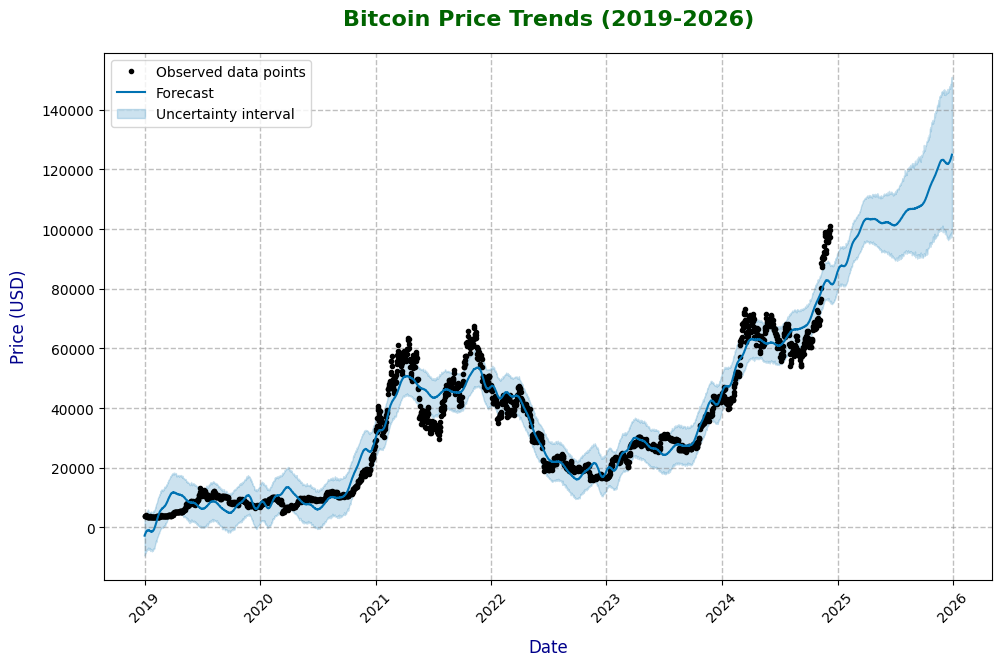

In [73]:
# From the forecast_bitcoin_trends DataFrame, plot the data to visualize
m.plot(forecast_bitcoin_trends);

plt.xlabel("Date", fontsize=12, labelpad=10, color='darkblue')  # Label font and spacing
plt.ylabel("Price (USD)", fontsize=12, labelpad=10, color='darkblue')  # Label font and spacing
plt.title("Bitcoin Price Trends (2019-2026)", fontsize=16, fontweight='bold', color='darkgreen', pad=20)  # Bold and larger title
# Formatting x-axis for better readability
plt.xticks(rotation=45, fontsize=10)  # Rotate x-ticks
# Grid and legend
plt.grid(True, linestyle='--', alpha=0.5)  # Add grid with light styling
plt.legend(loc='upper left', fontsize=10)  # Add legend
plt.show()

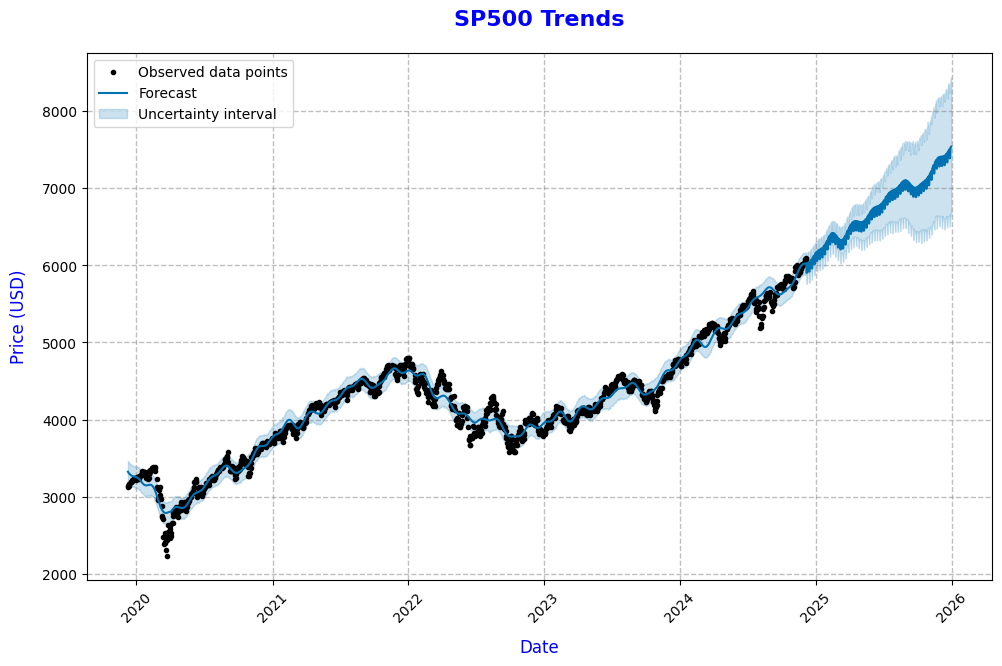

In [74]:
m1.plot(forecast_sp500_trends);
plt.xlabel("Date", fontsize=12, labelpad=10, color='blue')  # Label font and spacing
plt.ylabel("Price (USD)", fontsize=12, labelpad=10, color='blue')  # Label font and spacing
plt.title("SP500 Trends", fontsize=16, fontweight='bold', color='Blue', pad=20)  # Bold and larger title
# Formatting x-axis for better readability
plt.xticks(rotation=45, fontsize=10)  # Rotate x-ticks
# Grid and legend
plt.grid(True, linestyle='--', alpha=0.5)  # Add grid with light styling
plt.legend(loc='upper left', fontsize=10)  # Add legend
plt.show()



In [75]:
# Save the forecast dataframe to a csv
forecast_bitcoin_trends.to_csv("forecast_bitcoin_trends.csv")

In [76]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
bitcoin_df['Stock Volatility'] = bitcoin_df['Price'].rolling(window=4).std()
bitcoin_df.head()

,Date,Price,Open,High,Low,Volume,Stock Volatility
0,2021-08-03,38130.3,39167.4,39766.6,37688.2,260.0,NaN
1,2020-12-25,24689.6,23728.7,24778.9,23445.3,2400.0,NaN
2,2021-08-16,45996.3,46991.6,48002.4,45672.1,2410.0,NaN
3,2021-03-04,48428.0,50388.0,51757.7,47521.8,9560.0,10692.556843
4,2023-08-12,29428.2,29420.8,29480.8,29375.4,11070.0,11836.908845


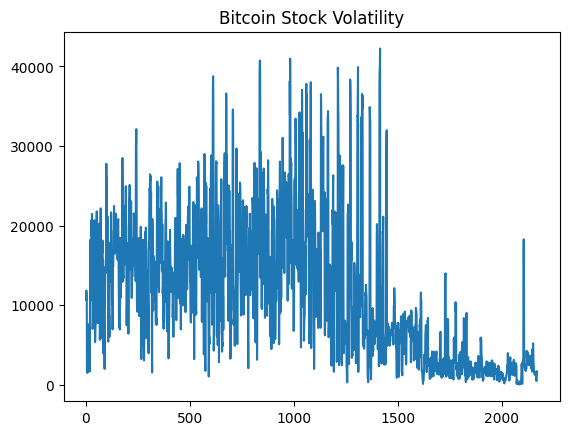

In [77]:
# Visualize the stock volatility
bitcoin_df['Stock Volatility'].plot(title="Bitcoin Stock Volatility");


In [78]:
# Export new dataframe for bitcoin_analysis_dataframe
bitcoin_df.to_csv("bitcoin_analysis_dataframe.csv")
bitcoin_df.head()

,Date,Price,Open,High,Low,Volume,Stock Volatility
0,2021-08-03,38130.3,39167.4,39766.6,37688.2,260.0,NaN
1,2020-12-25,24689.6,23728.7,24778.9,23445.3,2400.0,NaN
2,2021-08-16,45996.3,46991.6,48002.4,45672.1,2410.0,NaN
3,2021-03-04,48428.0,50388.0,51757.7,47521.8,9560.0,10692.556843
4,2023-08-12,29428.2,29420.8,29480.8,29375.4,11070.0,11836.908845
